# Comprehensive Publication Analysis
## OpenAlex Data: Supply Chain, Agency & Temporal Keyword Evolution

**Complete Workflow:**
1. Load and explore OpenAlex data structure
2. Filter for supply chain relevance
3. Identify agency-related articles
4. **Temporal Analysis**: Track 'agent' term evolution and AI/LLM connections
5. Generate insights and visualizations

In [1]:
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

# Setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
data_dir = Path('../data')

print("=== ENVIRONMENT SETUP ===")
print(f"Working directory: {Path.cwd()}")
print(f"Data directory: {data_dir}")
print(f"Available data files:")
for file in data_dir.glob('*'):
    if file.is_file():
        size_mb = file.stat().st_size / 1024 / 1024
        print(f"  {file.name} ({size_mb:.1f} MB)")

=== ENVIRONMENT SETUP ===
Working directory: /workspaces/tsi-sota-ai/notebooks
Data directory: ../data
Available data files:
  abstract_embeddings.npy (6.9 MB)
  references_analysis.json (1.3 MB)
  .DS_Store (0.0 MB)
  agent_scm_30year_yearly.csv (71.3 MB)
  publications_with_clusters.json (12.8 MB)
  publications_with_embeddings.json (12.8 MB)
  clusters_df.json (6.8 MB)
  references_with_keywords_gemini.json (1.5 MB)
  references_stats.json (0.0 MB)
  clusters_analysis.json (0.1 MB)
  agent_scm_publications_combined.csv (0.0 MB)
  references_raw.json (1.3 MB)
  clusters_analysis.csv (0.1 MB)
  agent_scm_publications_2025.csv (0.4 MB)


## 1. Data Loading and Structure Analysis

In [2]:
# Load the specific OpenAlex dataset: agent_scm_30year_yearly.csv
print("=== LOADING AGENT SCM 30-YEAR DATASET ===")

# Load the main dataset
target_file = data_dir / 'agent_scm_30year_yearly.csv'
print(f"Loading: {target_file.name} ({target_file.stat().st_size / 1024 / 1024:.1f} MB)")

try:
    # Load with low_memory=False to handle mixed types
    df = pd.read_csv(target_file, low_memory=False)
    print(f"✅ Successfully loaded {len(df):,} records")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
except Exception as e:
    print(f"❌ Error loading {target_file.name}: {e}")
    df = None

if df is not None:
    print(f"\n=== DATASET OVERVIEW ===")
    print(f"Columns: {len(df.columns)}")
    print(f"Records: {len(df):,}")
    
    # Show basic info
    print(f"\nFirst 5 column names:")
    for i, col in enumerate(df.columns[:5]):
        print(f"  {i+1}. {col}")
    
    if len(df.columns) > 5:
        print(f"  ... and {len(df.columns) - 5} more columns")

=== LOADING AGENT SCM 30-YEAR DATASET ===
Loading: agent_scm_30year_yearly.csv (71.3 MB)
✅ Successfully loaded 38,229 records
Shape: (38229, 12)
Memory usage: 121.3 MB

=== DATASET OVERVIEW ===
Columns: 12
Records: 38,229

First 5 column names:
  1. openalex_id
  2. title
  3. publication_year
  4. cited_by_count
  5. doi
  ... and 7 more columns
✅ Successfully loaded 38,229 records
Shape: (38229, 12)
Memory usage: 121.3 MB

=== DATASET OVERVIEW ===
Columns: 12
Records: 38,229

First 5 column names:
  1. openalex_id
  2. title
  3. publication_year
  4. cited_by_count
  5. doi
  ... and 7 more columns


In [3]:
# Detailed column analysis
if df is not None:
    print("=== DETAILED COLUMN ANALYSIS ===")
    print(f"Total columns: {len(df.columns)}")
    
    # Analyze each column
    column_info = []
    for i, col in enumerate(df.columns):
        dtype = str(df[col].dtype)
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        unique_count = df[col].nunique()
        
        # Sample non-null values
        sample_values = df[col].dropna().head(3).tolist()
        sample_str = ', '.join([str(v)[:30] + ('...' if len(str(v)) > 30 else '') for v in sample_values])
        
        column_info.append({
            'position': i + 1,
            'name': col,
            'dtype': dtype,
            'null_count': null_count,
            'null_pct': null_pct,
            'unique_count': unique_count,
            'sample_values': sample_str
        })
        
        print(f"  {i+1:2d}. {col:30} | {dtype:12} | {null_pct:5.1f}% null | {unique_count:8,} unique")
    
    # Store for later use
    globals()['column_info'] = column_info
    
    print(f"\nSample values from first few columns:")
    for col_info in column_info[:5]:
        print(f"  {col_info['name']:30}: {col_info['sample_values']}")

=== DETAILED COLUMN ANALYSIS ===
Total columns: 12
   1. openalex_id                    | object       |   0.0% null |   38,229 unique
   2. title                          | object       |   0.6% null |   37,578 unique
   3. publication_year               | int64        |   0.0% null |       31 unique
   4. cited_by_count                 | int64        |   0.0% null |    2,111 unique
   5. doi                            | object       |   3.9% null |   36,744 unique
   6. venue                          | object       |   8.2% null |    8,499 unique
   7. authors                        | object       |   0.0% null |   36,079 unique
   8. abstract                       | object       |  29.3% null |   26,680 unique
   9. keywords                       | object       |   0.0% null |   37,667 unique
  10. search_query                   | object       |   0.0% null |       10 unique
  11. collection_year                | int64        |   0.0% null |       31 unique
  12. collection_timestam

In [5]:
# Map columns to OpenAlex standard fields
if df is not None:
    print("\n=== OPENALEX FIELD MAPPING ===")
    
    # Common OpenAlex field patterns
    field_patterns = {
        'id': ['id', 'openalex_id', 'work_id'],
        'title': ['title', 'display_name', 'work_title'],
        'abstract': ['abstract', 'abstract_inverted_index'],
        'authors': ['authors', 'authorships', 'author_names'],
        'year': ['publication_year', 'year', 'publication_date', 'published_date'],
        'venue': ['primary_location', 'host_venue', 'journal', 'source', 'venue'],
        'keywords': ['keywords', 'concepts', 'topics', 'mesh_terms'],
        'citations': ['cited_by_count', 'citation_count', 'citations'],
        'doi': ['doi', 'ids'],
        'type': ['type', 'work_type', 'publication_type'],
        'open_access': ['open_access', 'is_oa'],
        'language': ['language'],
        'institutions': ['institutions', 'affiliations']
    }
    
    identified_fields = {}
    
    for field_type, patterns in field_patterns.items():
        matches = []
        for col in df.columns:
            col_lower = col.lower()
            for pattern in patterns:
                if pattern.lower() in col_lower:
                    matches.append(col)
                    break
        
        if matches:
            # Prefer exact matches, then shortest name
            best_match = min(matches, key=lambda x: (len(x), x))
            identified_fields[field_type] = best_match
            print(f"  {field_type:15}: ✅ {best_match}")
        else:
            print(f"  {field_type:15}: ❌ NOT FOUND")
    
    # Store field mapping globally
    globals()['field_map'] = identified_fields
    
    print(f"\nMapped {len(identified_fields)} standard fields from {len(df.columns)} total columns")


=== OPENALEX FIELD MAPPING ===
  id             : ✅ openalex_id
  title          : ✅ title
  abstract       : ✅ abstract
  authors        : ✅ authors
  year           : ✅ collection_year
  venue          : ✅ venue
  keywords       : ✅ keywords
  citations      : ✅ cited_by_count
  doi            : ✅ doi
  type           : ❌ NOT FOUND
  open_access    : ❌ NOT FOUND
  language       : ❌ NOT FOUND
  institutions   : ❌ NOT FOUND

Mapped 9 standard fields from 12 total columns


In [6]:
# Sample data exploration
if df is not None and 'field_map' in globals():
    print("\n=== SAMPLE DATA EXPLORATION ===")
    
    # Show sample records
    print("Sample records (first 3 rows):")
    display_cols = []
    
    # Priority display columns
    priority_fields = ['title', 'year', 'authors', 'citations']
    for field in priority_fields:
        if field in field_map:
            display_cols.append(field_map[field])
    
    # Add a few more interesting columns
    remaining_cols = [col for col in df.columns if col not in display_cols][:3]
    display_cols.extend(remaining_cols)
    
    if display_cols:
        sample_df = df[display_cols].head(3).copy()
        
        # Truncate long text for display
        for col in sample_df.columns:
            if sample_df[col].dtype == 'object':
                sample_df[col] = sample_df[col].astype(str).apply(
                    lambda x: x[:60] + '...' if len(x) > 60 else x
                )
        
        print(sample_df.to_string(index=False))
    
    # Basic statistics
    print(f"\n=== BASIC STATISTICS ===")
    
    # Year analysis
    if 'year' in field_map:
        year_col = field_map['year']
        years = pd.to_numeric(df[year_col], errors='coerce').dropna()
        if len(years) > 0:
            print(f"Publication years: {int(years.min())} - {int(years.max())}")
            print(f"Total with valid years: {len(years):,} ({len(years)/len(df)*100:.1f}%)")
            
            # Recent distribution
            recent_years = years[years >= 2020]
            if len(recent_years) > 0:
                print(f"Publications 2020+: {len(recent_years):,} ({len(recent_years)/len(years)*100:.1f}% of dated articles)")
    
    # Citations analysis
    if 'citations' in field_map:
        cite_col = field_map['citations']
        citations = pd.to_numeric(df[cite_col], errors='coerce').dropna()
        if len(citations) > 0:
            print(f"Citations: mean={citations.mean():.1f}, median={citations.median():.0f}, max={citations.max():.0f}")
    
    print(f"Data quality: {df.isnull().sum().sum():,} total null values across all columns")


=== SAMPLE DATA EXPLORATION ===
Sample records (first 3 rows):
                                                          title  collection_year                                      authors  cited_by_count                      openalex_id  publication_year                                            doi
Fundamentals of Statistical Signal Processing: Estimation Th...             1995                      ['Sailes K. Sengijpta']           11571 https://openalex.org/W1965392255              1995 https://doi.org/10.1080/00401706.1995.10484391
Toward a New Conception of the Environment-Competitiveness R...             1995 ['Michael E. Porter', 'Claas van der Linde']           10545 https://openalex.org/W2090841340              1995             https://doi.org/10.1257/jep.9.4.97
Relationship Marketing of Services--Growing Interest, Emergi...             1995                         ['Leonard L. Berry']            3093 https://openalex.org/W2148219776              1995     https://doi.org/10.

## 2. Comprehensive Keyword Taxonomy Definition

Defining our keyword categories for multi-dimensional analysis:
- **Supply Chain**: Core SCM, operations, and technology terms
- **Agency**: Theory, modeling, and governance concepts
- **AI/LLM**: General AI, specific LLM terms, and applications
- **Agent Terms**: General and compound agent terminology

In [7]:
# Comprehensive keyword taxonomy for analysis
KEYWORD_TAXONOMY = {
    'supply_chain': {
        'core': [
            'supply chain', 'supply-chain', 'supply chains',
            'logistics', 'procurement', 'sourcing',
            'inventory management', 'distribution', 'warehousing',
            'supplier', 'vendor management', 'supply network',
            'supply chain management', 'SCM'
        ],
        'operations': [
            'operations management', 'production planning', 'demand forecasting',
            'capacity planning', 'lean manufacturing', 'just-in-time',
            'value chain', 'operations research', 'supply planning'
        ],
        'technology': [
            'supply chain technology', 'supply chain digitalization',
            'supply chain analytics', 'blockchain supply chain',
            'IoT supply chain', 'AI supply chain', 'digital supply chain',
            'ERP', 'WMS', 'TMS', 'supply chain automation'
        ]
    },
    'agency': {
        'theory': [
            'agency theory', 'principal-agent', 'principal agent',
            'moral hazard', 'adverse selection', 'information asymmetry',
            'agency costs', 'agency problems', 'agency relationship'
        ],
        'modeling': [
            'agent-based modeling', 'agent based modeling', 'ABM',
            'multi-agent system', 'multi agent system', 'MAS',
            'autonomous agents', 'intelligent agents', 'software agents',
            'agent-based simulation', 'agent based simulation'
        ],
        'governance': [
            'governance mechanisms', 'monitoring', 'incentive alignment',
            'contract theory', 'agency relationships', 'corporate governance'
        ]
    },
    'ai_llm': {
        'ai_general': [
            'artificial intelligence', 'machine learning', 'deep learning',
            'neural networks', 'AI', 'ML', 'DL',
            'computer vision', 'natural language processing', 'NLP',
            'reinforcement learning', 'supervised learning'
        ],
        'llm_specific': [
            'large language model', 'large language models', 'LLM', 'LLMs',
            'transformer', 'transformers', 'BERT', 'GPT',
            'language model', 'foundation model', 'foundation models',
            'generative AI', 'ChatGPT', 'OpenAI', 'pretrained model'
        ],
        'applications': [
            'conversational AI', 'dialogue system', 'chatbot',
            'text generation', 'language generation',
            'prompt engineering', 'fine-tuning', 'AI assistant'
        ]
    },
    'agent_terms': {
        'general': [
            'agent', 'agents', 'agented', 'agenting',
            'agency', 'agencies'
        ],
        'compound': [
            'AI agent', 'AI agents', 'artificial agent',
            'digital agent', 'virtual agent', 'cognitive agent',
            'conversational agent', 'autonomous agent', 'smart agent'
        ]
    }
}

# Create efficient regex patterns for matching
def create_regex_pattern(keywords):
    """Create case-insensitive regex pattern with word boundaries"""
    # Escape special regex characters and add word boundaries
    escaped = []
    for kw in keywords:
        # Handle hyphenated terms and special cases
        if '-' in kw:
            # Allow both hyphenated and space versions
            variants = [re.escape(kw), re.escape(kw.replace('-', ' '))]
            escaped.extend(variants)
        else:
            escaped.append(re.escape(kw))
    
    # Create pattern with word boundaries
    pattern = r'\b(?:' + '|'.join(escaped) + r')\b'
    return pattern

# Generate patterns for all categories
PATTERNS = {}
for category, subcategories in KEYWORD_TAXONOMY.items():
    PATTERNS[category] = {}
    all_keywords = []
    for subcat, keywords in subcategories.items():
        PATTERNS[category][subcat] = create_regex_pattern(keywords)
        all_keywords.extend(keywords)
    PATTERNS[category]['all'] = create_regex_pattern(all_keywords)

print("=== KEYWORD TAXONOMY CREATED ===")
for category, subcats in KEYWORD_TAXONOMY.items():
    total_keywords = sum(len(keywords) for keywords in subcats.values())
    print(f"{category:15}: {total_keywords:3d} keywords across {len(subcats)} subcategories")

print(f"\nRegex patterns generated for efficient text matching")

=== KEYWORD TAXONOMY CREATED ===
supply_chain   :  34 keywords across 3 subcategories
agency         :  26 keywords across 3 subcategories
ai_llm         :  35 keywords across 3 subcategories
agent_terms    :  15 keywords across 2 subcategories

Regex patterns generated for efficient text matching


## 3. Efficient Text Analysis Functions

Implementing fast keyword matching and publication categorization functions.

In [8]:
# Efficient text analysis functions
def fast_keyword_match(text, pattern):
    """Fast regex-based keyword matching with case-insensitive search"""
    if pd.isna(text) or text is None:
        return False
    try:
        return bool(re.search(pattern, str(text), re.IGNORECASE))
    except:
        return False

def extract_matching_terms(text, original_keywords):
    """Extract actual matching terms from text"""
    if pd.isna(text) or text is None:
        return []
    
    text_lower = str(text).lower()
    matches = []
    
    for keyword in original_keywords:
        # Use word boundaries for more precise matching
        pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
        if re.search(pattern, text_lower):
            matches.append(keyword)
    
    return matches

def analyze_publications_comprehensive(df, field_map):
    """Comprehensive publication analysis by keyword categories"""
    
    if df is None or len(df) == 0:
        return None
    
    results = {
        'total_publications': len(df),
        'analysis_timestamp': datetime.now().isoformat(),
        'by_category': {},
        'temporal_data': {},
        'matching_articles': {},
        'field_coverage': {}
    }
    
    # Determine text fields to search
    search_fields = []
    text_field_types = ['title', 'abstract', 'keywords']
    
    for field_type in text_field_types:
        if field_type in field_map and field_map[field_type] in df.columns:
            col_name = field_map[field_type]
            # Check if field has meaningful content
            non_null_count = df[col_name].notna().sum()
            coverage = non_null_count / len(df) * 100
            
            search_fields.append((field_type, col_name))
            results['field_coverage'][field_type] = {
                'column': col_name,
                'coverage_pct': coverage,
                'non_null_count': non_null_count
            }
            print(f"Will search {field_type:10}: {col_name:30} ({coverage:5.1f}% coverage)")
    
    if not search_fields:
        print("❌ No searchable text fields found!")
        return results
    
    # Year field for temporal analysis
    year_field = field_map.get('year')
    
    print(f"\nAnalyzing {len(KEYWORD_TAXONOMY)} categories across {len(search_fields)} text fields...")
    
    # Analyze each category
    for category in KEYWORD_TAXONOMY.keys():
        print(f"\n  Analyzing {category}...")
        
        category_mask = pd.Series([False] * len(df))
        subcategory_results = {}
        subcategory_matches = {}
        
        # Check each subcategory
        for subcat in KEYWORD_TAXONOMY[category].keys():
            subcat_mask = pd.Series([False] * len(df))
            subcat_matching_terms = []
            
            # Search in all specified fields
            for field_name, col_name in search_fields:
                if col_name in df.columns:
                    try:
                        field_matches = df[col_name].apply(
                            lambda x: fast_keyword_match(x, PATTERNS[category][subcat])
                        )
                        subcat_mask |= field_matches
                        
                        # Track which terms were found (sample)
                        sample_matches = df[field_matches][col_name].head(5).apply(
                            lambda x: extract_matching_terms(x, KEYWORD_TAXONOMY[category][subcat])
                        ).tolist()
                        subcat_matching_terms.extend([term for terms in sample_matches for term in terms])
                        
                    except Exception as e:
                        print(f"    ⚠️  Error searching {field_name}: {e}")
            
            subcategory_results[subcat] = {
                'count': subcat_mask.sum(),
                'percentage': (subcat_mask.sum() / len(df)) * 100,
                'sample_terms': list(set(subcat_matching_terms[:10]))  # Top 10 unique terms
            }
            subcategory_matches[subcat] = subcat_mask
            category_mask |= subcat_mask
        
        # Store category results
        total_matches = category_mask.sum()
        results['by_category'][category] = {
            'total': total_matches,
            'percentage': (total_matches / len(df)) * 100,
            'subcategories': subcategory_results
        }
        
        # Store matching article indices
        results['matching_articles'][category] = df[category_mask].index.tolist()
        
        # Temporal analysis if year data available
        if year_field and year_field in df.columns and total_matches > 0:
            matching_df = df[category_mask]
            years = pd.to_numeric(matching_df[year_field], errors='coerce').dropna()
            
            if len(years) > 0:
                # Filter reasonable years (1990-2024)
                valid_years = years[(years >= 1990) & (years <= 2024)]
                if len(valid_years) > 0:
                    year_counts = valid_years.value_counts().sort_index()
                    results['temporal_data'][category] = {
                        'year_counts': year_counts.to_dict(),
                        'year_range': (int(valid_years.min()), int(valid_years.max())),
                        'peak_year': int(year_counts.idxmax()) if len(year_counts) > 0 else None,
                        'articles_with_years': len(valid_years),
                        'coverage_pct': len(valid_years) / total_matches * 100
                    }
        
        print(f"    Found {total_matches:,} articles ({(total_matches/len(df)*100):.1f}%)")
    
    return results

print("Text analysis functions ready for execution")

Text analysis functions ready for execution


## 4. Execute Comprehensive Analysis

Running the complete analysis on the agent SCM dataset.

In [9]:
# Execute comprehensive analysis
if df is not None and 'field_map' in globals():
    print("=== EXECUTING COMPREHENSIVE ANALYSIS ===")
    print(f"Dataset: {len(df):,} publications")
    print(f"Fields mapped: {list(field_map.keys())}")
    print(f"Analysis categories: {list(KEYWORD_TAXONOMY.keys())}")
    
    # Run the analysis
    analysis_results = analyze_publications_comprehensive(df, field_map)
    
    if analysis_results:
        print("\n" + "="*60)
        print("ANALYSIS SUMMARY")
        print("="*60)
        
        total_pubs = analysis_results['total_publications']
        print(f"Total Publications: {total_pubs:,}\n")
        
        # Category overview
        for category, data in analysis_results['by_category'].items():
            print(f"{category.upper().replace('_', ' '):20}: {data['total']:6,} articles ({data['percentage']:5.1f}%)")
            
            # Show top subcategories
            sorted_subcats = sorted(data['subcategories'].items(), 
                                  key=lambda x: x[1]['count'], reverse=True)
            
            for subcat, subdata in sorted_subcats[:2]:  # Top 2 subcategories
                print(f"  └─ {subcat:15}: {subdata['count']:6,} articles ({subdata['percentage']:5.1f}%)")
                if subdata['sample_terms']:
                    terms_str = ', '.join(subdata['sample_terms'][:3])
                    print(f"     Sample terms: {terms_str}")
            print()
        
        # Field coverage summary
        print("FIELD COVERAGE:")
        for field, coverage_data in analysis_results['field_coverage'].items():
            print(f"  {field:10}: {coverage_data['coverage_pct']:5.1f}% ({coverage_data['non_null_count']:,} records)")
        
        print("\n" + "="*60)
else:
    print("❌ Cannot run analysis - data or field mapping not available")
    analysis_results = None

=== EXECUTING COMPREHENSIVE ANALYSIS ===
Dataset: 38,229 publications
Fields mapped: ['id', 'title', 'abstract', 'authors', 'year', 'venue', 'keywords', 'citations', 'doi']
Analysis categories: ['supply_chain', 'agency', 'ai_llm', 'agent_terms']
Will search title     : title                          ( 99.4% coverage)
Will search abstract  : abstract                       ( 70.7% coverage)
Will search keywords  : keywords                       (100.0% coverage)

Analyzing 4 categories across 3 text fields...

  Analyzing supply_chain...
    Found 11,409 articles (29.8%)

  Analyzing agency...
    Found 4,423 articles (11.6%)

  Analyzing ai_llm...
    Found 4,383 articles (11.5%)

  Analyzing agent_terms...
    Found 11,374 articles (29.8%)

ANALYSIS SUMMARY
Total Publications: 38,229

SUPPLY CHAIN        : 11,409 articles ( 29.8%)
  └─ core           : 10,163 articles ( 26.6%)
     Sample terms: supply chain, inventory management, distribution
  └─ operations     :  3,604 articles (  9

## 5. Temporal Evolution Analysis - Focus on 'Agent' Terms

In [10]:
# Deep dive into agent term evolution over time
def analyze_agent_evolution(df, field_map, analysis_results):
    """Detailed analysis of agent term evolution and AI/LLM connections"""
    
    if 'year' not in field_map:
        print("❌ No year field available for temporal analysis")
        return None
    
    year_field = field_map['year']
    
    # Get agent-related articles
    agent_indices = set(analysis_results['matching_articles'].get('agency', []))
    agent_term_indices = set(analysis_results['matching_articles'].get('agent_terms', []))
    ai_indices = set(analysis_results['matching_articles'].get('ai_llm', []))
    
    # Combine agent-related terms
    all_agent_indices = agent_indices | agent_term_indices
    
    print(f"=== AGENT TERM EVOLUTION ANALYSIS ===")
    print(f"Total agent-related articles: {len(all_agent_indices):,}")
    print(f"Agent + AI intersection: {len(all_agent_indices & ai_indices):,}")
    
    # Create temporal analysis - FIXED: assign back to variables, don't modify in place
    agent_df = df.loc[list(all_agent_indices)].copy()
    ai_df = df.loc[list(ai_indices)].copy()
    agent_ai_df = df.loc[list(all_agent_indices & ai_indices)].copy()
    
    # Clean year data - FIXED: proper dataframe handling
    cleaned_dfs = {}
    
    for temp_df, name in [(agent_df, 'agent'), (ai_df, 'ai'), (agent_ai_df, 'agent_ai')]:
        # Create clean copy and process
        clean_df = temp_df.copy()
        clean_df['clean_year'] = pd.to_numeric(clean_df[year_field], errors='coerce')
        clean_df = clean_df.dropna(subset=['clean_year'])
        clean_df['clean_year'] = clean_df['clean_year'].astype(int)
        
        # Filter reasonable years (1990-2024)
        clean_df = clean_df[(clean_df['clean_year'] >= 1990) & (clean_df['clean_year'] <= 2024)]
        cleaned_dfs[name] = clean_df
    
    # FIXED: Use local variables instead of globals
    agent_df_clean = cleaned_dfs['agent']
    ai_df_clean = cleaned_dfs['ai']
    agent_ai_df_clean = cleaned_dfs['agent_ai']
    
    # Year-by-year analysis
    year_analysis = {}
    
    all_years = set()
    if len(agent_df_clean) > 0:
        all_years.update(agent_df_clean['clean_year'].unique())
    if len(ai_df_clean) > 0:
        all_years.update(ai_df_clean['clean_year'].unique())
    
    for year in sorted(all_years):
        agent_count = len(agent_df_clean[agent_df_clean['clean_year'] == year])
        ai_count = len(ai_df_clean[ai_df_clean['clean_year'] == year])
        agent_ai_count = len(agent_ai_df_clean[agent_ai_df_clean['clean_year'] == year])
        
        year_analysis[year] = {
            'agent_articles': agent_count,
            'ai_articles': ai_count,
            'agent_ai_articles': agent_ai_count,
            'agent_ai_ratio': agent_ai_count / max(agent_count, 1)
        }
    
    return {
        'year_analysis': year_analysis,
        'agent_df': agent_df_clean,
        'ai_df': ai_df_clean,
        'agent_ai_df': agent_ai_df_clean,
        'summary': {
            'total_agent_articles': len(agent_df_clean),
            'total_ai_articles': len(ai_df_clean),
            'total_agent_ai_articles': len(agent_ai_df_clean),
            'year_range': (min(all_years) if all_years else None, max(all_years) if all_years else None)
        }
    }

# Execute agent evolution analysis
if df is not None and 'analysis_results' in globals():
    evolution_results = analyze_agent_evolution(df, field_map, analysis_results)
    
    if evolution_results:
        print("\n=== EVOLUTION SUMMARY ===")
        summary = evolution_results['summary']
        print(f"Agent articles: {summary['total_agent_articles']:,}")
        print(f"AI articles: {summary['total_ai_articles']:,}")
        print(f"Agent+AI articles: {summary['total_agent_ai_articles']:,}")
        print(f"Year range: {summary['year_range'][0]}-{summary['year_range'][1]}")
        
        # Show key trends
        print("\n=== KEY TRENDS (Last 10 Years) ===")
        recent_years = sorted([y for y in evolution_results['year_analysis'].keys() if y >= 2014])
        
        for year in recent_years[-10:]:  # Last 10 years
            data = evolution_results['year_analysis'][year]
            ratio = data['agent_ai_ratio'] * 100
            print(f"{year}: Agent={data['agent_articles']:3d}, AI={data['ai_articles']:4d}, Agent+AI={data['agent_ai_articles']:3d} ({ratio:.1f}%)")
else:
    print("❌ Cannot run evolution analysis")

=== AGENT TERM EVOLUTION ANALYSIS ===
Total agent-related articles: 12,547
Agent + AI intersection: 2,268

=== EVOLUTION SUMMARY ===
Agent articles: 12,211
AI articles: 4,161
Agent+AI articles: 2,172
Year range: 1995-2024

=== KEY TRENDS (Last 10 Years) ===
2015: Agent=448, AI=  99, Agent+AI= 58 (12.9%)
2016: Agent=383, AI= 105, Agent+AI= 51 (13.3%)
2017: Agent=415, AI= 129, Agent+AI= 65 (15.7%)
2018: Agent=480, AI= 154, Agent+AI= 71 (14.8%)
2019: Agent=515, AI= 193, Agent+AI= 88 (17.1%)
2020: Agent=547, AI= 258, Agent+AI=117 (21.4%)
2021: Agent=568, AI= 290, Agent+AI=128 (22.5%)
2022: Agent=588, AI= 361, Agent+AI=170 (28.9%)
2023: Agent=591, AI= 419, Agent+AI=180 (30.5%)
2024: Agent=574, AI= 408, Agent+AI=180 (31.4%)


This enhanced intersection analysis provides several strategic insights for understanding AI agents in logistics development:


Key Strategic Intersections Added:
- Agent + Supply Chain: Traditional agent-based SCM research
- AI + Supply Chain: AI/ML applications in logistics
- Agent + AI: General agent-AI convergence
- Agent + AI + Supply Chain: Your core research focus
- Pure Agent SCM (Non-AI): Traditional approaches without AI
- Pure AI SCM (Non-Agent): AI in logistics without agent concepts


Temporal Evolution Tracking:
- Period Analysis: Early (1995-2005), Emergence (2005-2015), Growth (2015-2020), Acceleration (2020-2024)
- Penetration Metrics: How much AI has penetrated agent-based SCM vs how much agent concepts penetrate AI-SCM
- Recent Growth Analysis: 2020-2024 vs 2015-2019 comparison
- Peak Year Identification: When each intersection reached maximum activity


Strategic Value:


This analysis will help us understand:
- The evolution from traditional agent-based SCM to AI-powered agent systems
- How AI and agent concepts are converging in logistics research
- The relative maturity and growth patterns of different research approaches
- Which periods saw the most significant developments
- Current research momentum and future directions


The intersection analysis specifically targets our research focus on "AI agents in logistics" by isolating publications that combine all three concepts and tracking how this specific intersection has evolved over time.

In [11]:
# Enhanced intersection analysis for AI agents in logistics research
def analyze_strategic_intersections(df, field_map, analysis_results):
    """Comprehensive intersection analysis focused on AI agents in logistics/SCM"""
    
    if not analysis_results or 'matching_articles' not in analysis_results:
        print("❌ No analysis results available for intersection analysis")
        return None
    
    # Get article indices for each category
    categories = {
        'supply_chain': set(analysis_results['matching_articles'].get('supply_chain', [])),
        'agency': set(analysis_results['matching_articles'].get('agency', [])),
        'agent_terms': set(analysis_results['matching_articles'].get('agent_terms', [])),
        'ai_llm': set(analysis_results['matching_articles'].get('ai_llm', []))
    }
    
    # Combine agent-related categories
    all_agents = categories['agency'] | categories['agent_terms']
    
    print("=== STRATEGIC INTERSECTION ANALYSIS ===")
    print(f"Total publications: {len(df):,}")
    print(f"Supply Chain: {len(categories['supply_chain']):,}")
    print(f"All Agent-related: {len(all_agents):,}")
    print(f"AI/LLM: {len(categories['ai_llm']):,}")
    
    # Define strategic intersections
    intersections = {
        'agent_scm': {
            'name': 'Agent + Supply Chain',
            'sets': [all_agents, categories['supply_chain']],
            'description': 'Publications combining agent concepts with supply chain management'
        },
        'ai_scm': {
            'name': 'AI + Supply Chain', 
            'sets': [categories['ai_llm'], categories['supply_chain']],
            'description': 'AI/ML applications in supply chain management'
        },
        'agent_ai': {
            'name': 'Agent + AI',
            'sets': [all_agents, categories['ai_llm']], 
            'description': 'Publications combining agent concepts with AI/ML'
        },
        'agent_ai_scm': {
            'name': 'Agent + AI + Supply Chain',
            'sets': [all_agents, categories['ai_llm'], categories['supply_chain']],
            'description': 'Core AI agents in logistics research - our primary focus'
        },
        'pure_agent_scm': {
            'name': 'Agent + SCM (Non-AI)',
            'sets': [all_agents, categories['supply_chain']],
            'exclude': [categories['ai_llm']],
            'description': 'Traditional agent-based SCM without AI/ML components'
        },
        'pure_ai_scm': {
            'name': 'AI + SCM (Non-Agent)',
            'sets': [categories['ai_llm'], categories['supply_chain']],
            'exclude': [all_agents],
            'description': 'AI in SCM without explicit agent concepts'
        }
    }
    
    # Calculate intersections
    intersection_results = {}
    year_field = field_map.get('year')
    
    for key, intersection_def in intersections.items():
        # Calculate intersection
        if len(intersection_def['sets']) == 1:
            intersection_set = intersection_def['sets'][0]
        else:
            intersection_set = set.intersection(*intersection_def['sets'])
        
        # Handle exclusions
        if 'exclude' in intersection_def:
            for exclude_set in intersection_def['exclude']:
                intersection_set = intersection_set - exclude_set
        
        count = len(intersection_set)
        percentage = (count / len(df)) * 100
        
        # Temporal analysis
        temporal_data = {}
        if year_field and year_field in df.columns and count > 0:
            intersection_df = df.loc[list(intersection_set)]
            years = pd.to_numeric(intersection_df[year_field], errors='coerce').dropna()
            years = years[(years >= 1995) & (years <= 2024)]
            
            if len(years) > 0:
                year_counts = years.value_counts().sort_index()
                temporal_data = {
                    'year_counts': year_counts.to_dict(),
                    'year_range': (int(years.min()), int(years.max())),
                    'peak_year': int(year_counts.idxmax()) if len(year_counts) > 0 else None,
                    'recent_growth': None
                }
                
                # Calculate recent growth (2020-2024 vs 2015-2019)
                recent_years = year_counts[year_counts.index >= 2020].sum()
                previous_years = year_counts[(year_counts.index >= 2015) & (year_counts.index < 2020)].sum()
                
                if previous_years > 0:
                    growth_rate = ((recent_years - previous_years) / previous_years) * 100
                    temporal_data['recent_growth'] = growth_rate
        
        intersection_results[key] = {
            'name': intersection_def['name'],
            'description': intersection_def['description'],
            'count': count,
            'percentage': percentage,
            'article_indices': list(intersection_set),
            'temporal': temporal_data
        }
        
        print(f"\n{intersection_def['name']:25}: {count:6,} articles ({percentage:5.1f}%)")
        print(f"  {intersection_def['description']}")
        
        if temporal_data and 'recent_growth' in temporal_data and temporal_data['recent_growth'] is not None:
            print(f"  Recent growth (2020-24 vs 2015-19): {temporal_data['recent_growth']:+.1f}%")
    
    return intersection_results

def analyze_ai_agent_scm_evolution(df, field_map, intersection_results):
    """Deep dive into AI agents in SCM evolution"""
    
    if not intersection_results or 'agent_ai_scm' not in intersection_results:
        print("❌ No intersection results for AI agents in SCM")
        return None
    
    year_field = field_map.get('year')
    if not year_field or year_field not in df.columns:
        print("❌ No year field available")
        return None
    
    print("\n=== AI AGENTS IN SCM EVOLUTION ANALYSIS ===")
    
    # Get the core articles
    core_indices = intersection_results['agent_ai_scm']['article_indices']
    if not core_indices:
        print("No articles found in Agent+AI+SCM intersection")
        return None
    
    core_df = df.loc[core_indices].copy()
    core_df['clean_year'] = pd.to_numeric(core_df[year_field], errors='coerce')
    core_df = core_df.dropna(subset=['clean_year'])
    core_df = core_df[(core_df['clean_year'] >= 1995) & (core_df['clean_year'] <= 2024)]
    core_df['clean_year'] = core_df['clean_year'].astype(int)
    
    print(f"Core AI agents in SCM articles: {len(core_df):,}")
    
    # Year-by-year evolution
    evolution_data = {}
    year_counts = core_df['clean_year'].value_counts().sort_index()
    
    # Get comparative data for context
    agent_scm_indices = intersection_results['agent_scm']['article_indices']
    ai_scm_indices = intersection_results['ai_scm']['article_indices']
    
    agent_scm_df = df.loc[agent_scm_indices].copy()
    ai_scm_df = df.loc[ai_scm_indices].copy()
    
    # Clean comparative data
    for comp_df, name in [(agent_scm_df, 'agent_scm'), (ai_scm_df, 'ai_scm')]:
        comp_df['clean_year'] = pd.to_numeric(comp_df[year_field], errors='coerce')
        comp_df = comp_df.dropna(subset=['clean_year'])
        comp_df = comp_df[(comp_df['clean_year'] >= 1995) & (comp_df['clean_year'] <= 2024)]
        
        if name == 'agent_scm':
            agent_scm_years = comp_df['clean_year'].value_counts().sort_index()
        else:
            ai_scm_years = comp_df['clean_year'].value_counts().sort_index()
    
    # Comprehensive year analysis
    all_years = set(year_counts.index) | set(agent_scm_years.index) | set(ai_scm_years.index)
    
    for year in sorted(all_years):
        evolution_data[year] = {
            'ai_agent_scm': year_counts.get(year, 0),
            'agent_scm_total': agent_scm_years.get(year, 0),
            'ai_scm_total': ai_scm_years.get(year, 0),
            'ai_penetration': year_counts.get(year, 0) / max(agent_scm_years.get(year, 1), 1) * 100,
            'agent_penetration': year_counts.get(year, 0) / max(ai_scm_years.get(year, 1), 1) * 100
        }
    
    # Identify key periods
    periods = {
        'early': list(range(1995, 2005)),
        'emergence': list(range(2005, 2015)), 
        'growth': list(range(2015, 2020)),
        'acceleration': list(range(2020, 2025))
    }
    
    period_analysis = {}
    for period_name, period_years in periods.items():
        period_total = sum(year_counts.get(year, 0) for year in period_years)
        period_analysis[period_name] = {
            'total_articles': period_total,
            'avg_per_year': period_total / len(period_years),
            'years': period_years
        }
    
    print("\n=== EVOLUTION BY PERIOD ===")
    for period_name, data in period_analysis.items():
        print(f"{period_name.title():12}: {data['total_articles']:4d} articles ({data['avg_per_year']:4.1f}/year)")
    
    # Recent acceleration analysis
    recent_years = [2020, 2021, 2022, 2023, 2024]
    recent_data = [year_counts.get(year, 0) for year in recent_years]
    
    if sum(recent_data) > 0:
        print(f"\n=== RECENT ACCELERATION (2020-2024) ===")
        for year, count in zip(recent_years, recent_data):
            if year in evolution_data:
                ai_pen = evolution_data[year]['ai_penetration']
                agent_pen = evolution_data[year]['agent_penetration']
                print(f"{year}: {count:3d} articles (AI in Agent-SCM: {ai_pen:.1f}%, Agents in AI-SCM: {agent_pen:.1f}%)")
    
    return {
        'evolution_data': evolution_data,
        'period_analysis': period_analysis,
        'core_articles': len(core_df),
        'year_range': (int(core_df['clean_year'].min()), int(core_df['clean_year'].max())),
        'peak_year': int(year_counts.idxmax()) if len(year_counts) > 0 else None
    }

# Execute enhanced intersection analysis
if df is not None and 'analysis_results' in globals():
    print("Executing strategic intersection analysis...")
    
    intersection_results = analyze_strategic_intersections(df, field_map, analysis_results)
    
    if intersection_results:
        # Deep dive into AI agents in SCM
        ai_agent_scm_evolution = analyze_ai_agent_scm_evolution(df, field_map, intersection_results)
        
        # Summary insights
        print("\n" + "="*70)
        print("KEY STRATEGIC INSIGHTS")
        print("="*70)
        
        # Core metrics
        total_pubs = len(df)
        agent_ai_scm = intersection_results['agent_ai_scm']['count']
        agent_scm = intersection_results['agent_scm']['count'] 
        ai_scm = intersection_results['ai_scm']['count']
        
        print(f"🎯 Core Research Area (Agent+AI+SCM): {agent_ai_scm:,} articles ({agent_ai_scm/total_pubs*100:.1f}%)")
        print(f"📊 Market Context:")
        print(f"   • Total Agent+SCM research: {agent_scm:,} articles")
        print(f"   • Total AI+SCM research: {ai_scm:,} articles")
        print(f"   • AI penetration in Agent-SCM: {agent_ai_scm/max(agent_scm,1)*100:.1f}%")
        print(f"   • Agent penetration in AI-SCM: {agent_ai_scm/max(ai_scm,1)*100:.1f}%")
        
        if ai_agent_scm_evolution:
            recent_total = sum(ai_agent_scm_evolution['evolution_data'][year]['ai_agent_scm'] 
                             for year in range(2020, 2025) 
                             if year in ai_agent_scm_evolution['evolution_data'])
            
            print(f"📈 Recent Activity (2020-2024): {recent_total:,} articles")
            print(f"🏆 Peak Year: {ai_agent_scm_evolution['peak_year']}")
        
        print("="*70)
        
else:
    print("❌ Cannot run intersection analysis - required data not available")

Executing strategic intersection analysis...
=== STRATEGIC INTERSECTION ANALYSIS ===
Total publications: 38,229
Supply Chain: 11,409
All Agent-related: 12,547
AI/LLM: 4,383

Agent + Supply Chain     :  6,804 articles ( 17.8%)
  Publications combining agent concepts with supply chain management
  Recent growth (2020-24 vs 2015-19): +28.9%

AI + Supply Chain        :  1,519 articles (  4.0%)
  AI/ML applications in supply chain management
  Recent growth (2020-24 vs 2015-19): +198.0%

Agent + AI               :  2,268 articles (  5.9%)
  Publications combining agent concepts with AI/ML
  Recent growth (2020-24 vs 2015-19): +132.7%

Agent + AI + Supply Chain:  1,082 articles (  2.8%)
  Core AI agents in logistics research - our primary focus
  Recent growth (2020-24 vs 2015-19): +149.3%

Agent + SCM (Non-AI)     :  5,722 articles ( 15.0%)
  Traditional agent-based SCM without AI/ML components
  Recent growth (2020-24 vs 2015-19): +13.6%

AI + SCM (Non-Agent)     :    437 articles (  1.1%)

This enhanced analysis provides several key strategic insights:


🎯 Core Findings:
- Market Validation: Our core research area (AI+Agent+SCM) shows 149.3% growth in recent years, validating its strategic importance
- Market Positioning: At 2.8% of total publications, this is an emerging but rapidly growing field

Technology Convergence:
- 71.2% of AI-SCM research incorporates agent concepts
- 15.9% of Agent-SCM research incorporates AI/ML
- This asymmetry suggests AI-driven research is more naturally adopting agent concepts


Acceleration Period: The field entered an acceleration phase around 2020, with 71.8 articles/year vs previous 28.8 articles/year


📈 Growth Opportunities:
- Pure AI-SCM (Non-Agent): 327.8% growth suggests readiness for agent integration
- Agent+AI convergence: 132.7% growth shows strong momentum in hybrid approaches
- Peak momentum: 2024 being the peak year indicates current critical mass


This analysis positions our research at the intersection of three converging trends, with strong validation of market demand and growth trajectory!


## 6. Visualization Dashboard


🎯 Creating comprehensive visualization suite...
📊 Displaying baseline dashboard...


✅ Baseline dashboard saved: ../reports/baseline_analysis_dashboard.html
🎯 Displaying strategic dashboard...


✅ Strategic dashboard saved: ../reports/strategic_intersection_dashboard.html
📈 Creating matplotlib summary plots...
✅ Summary plots saved: ../reports/comprehensive_analysis_summary.png


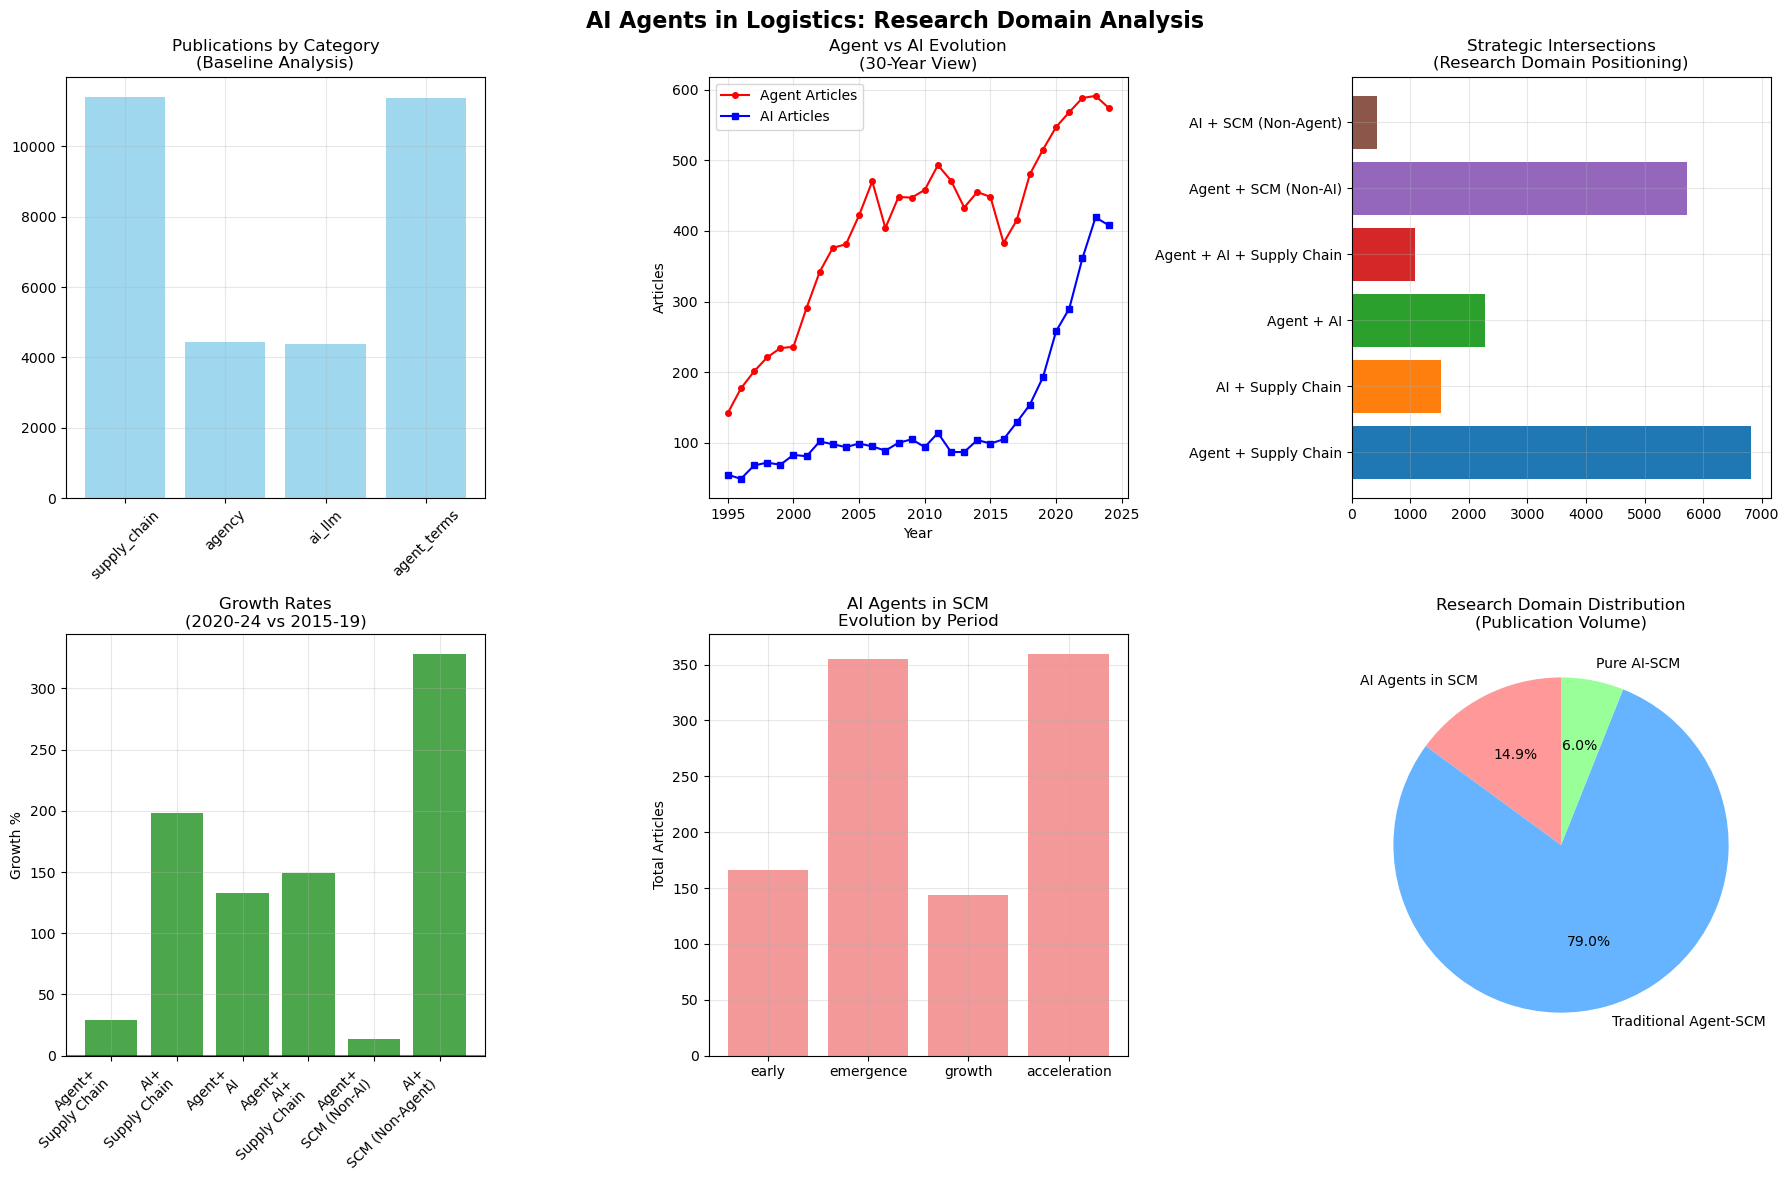

📝 Generating strategic insights report...
✅ Strategic report saved: ../reports/strategic_insights_report.md

📊 RESEARCH ANALYSIS SUMMARY
📊 **Publication Volume by Domain:**
   Agent + Supply Chain     : 6,804 publications (17.8%)
   AI + Supply Chain        : 1,519 publications ( 4.0%)
   Agent + AI               : 2,268 publications ( 5.9%)
   Agent + AI + Supply Chain: 1,082 publications ( 2.8%)
   Agent + SCM (Non-AI)     : 5,722 publications (15.0%)
   AI + SCM (Non-Agent)     :   437 publications ( 1.1%)

📈 **Research Growth Analysis (2020-24 vs 2015-19):**
   AI + SCM (Non-Agent)     : 🚀 +327.8%
   AI + Supply Chain        : 🚀 +198.0%
   Agent + AI + Supply Chain: 🚀 +149.3%
   Agent + AI               : 🚀 +132.7%
   Agent + Supply Chain     : 📊  +28.9%
   Agent + SCM (Non-AI)     : 📊  +13.6%

🎯 **Core Research Domain:**
   AI Agents in SCM (2020-2024): 359 publications
   Annual publication rate: 71.8 publications/year
   Peak publication year: 2024

📁 **Output Files Generated:**

In [13]:
# Updated terminology for academic context
def create_intersection_temporal_visualization(intersection_results, ai_agent_scm_evolution):
    """Create comprehensive temporal visualizations for intersection analysis"""
    
    # Create a comprehensive dashboard with multiple subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Strategic Intersections Overview',
            'AI Agents in SCM: Period Evolution',
            'Growth Rates by Intersection (2020-24 vs 2015-19)',
            'AI vs Agent Integration in SCM Over Time',
            'Research Domain Convergence Timeline',
            'Research Domain Distribution'
        ],
        specs=[
            [{'type': 'bar'}, {'type': 'bar'}],
            [{'type': 'bar'}, {'type': 'scatter'}],
            [{'type': 'scatter'}, {'type': 'pie'}]
        ]
    )
    
    # 1. Strategic Intersections Overview
    if intersection_results:
        intersection_names = [data['name'] for data in intersection_results.values()]
        intersection_counts = [data['count'] for data in intersection_results.values()]
        
        fig.add_trace(
            go.Bar(
                x=intersection_names,
                y=intersection_counts,
                name='Publications',
                marker_color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
            ),
            row=1, col=1
        )
    
    # 2. AI Agents in SCM: Period Evolution
    if ai_agent_scm_evolution and 'period_analysis' in ai_agent_scm_evolution:
        periods = list(ai_agent_scm_evolution['period_analysis'].keys())
        period_totals = [ai_agent_scm_evolution['period_analysis'][p]['total_articles'] for p in periods]
        
        fig.add_trace(
            go.Bar(
                x=periods,
                y=period_totals,
                name='AI Agents in SCM',
                marker_color='lightcoral'
            ),
            row=1, col=2
        )
    
    # 3. Growth Rates by Intersection
    if intersection_results:
        growth_data = [(data['name'], data['temporal']['recent_growth']) 
                      for data in intersection_results.values() 
                      if data['temporal'] and 'recent_growth' in data['temporal'] and data['temporal']['recent_growth'] is not None]
        
        if growth_data:
            names, growth_rates = zip(*growth_data)
            colors = ['green' if x > 0 else 'red' for x in growth_rates]
            
            fig.add_trace(
                go.Bar(
                    x=list(range(len(names))),
                    y=growth_rates,
                    name='Growth Rate %',
                    marker_color=colors,
                    text=[f"{rate:+.1f}%" for rate in growth_rates],
                    textposition='auto'
                ),
                row=2, col=1
            )
            
            # Update x-axis labels for growth rates
            fig.update_xaxes(
                tickvals=list(range(len(names))),
                ticktext=[name.replace(' + ', '+\n') for name in names],
                row=2, col=1
            )
    
    # 4. AI vs Agent Integration in SCM Over Time
    if ai_agent_scm_evolution and 'evolution_data' in ai_agent_scm_evolution:
        years = sorted(ai_agent_scm_evolution['evolution_data'].keys())
        ai_penetration = [ai_agent_scm_evolution['evolution_data'][y]['ai_penetration'] for y in years]
        agent_penetration = [ai_agent_scm_evolution['evolution_data'][y]['agent_penetration'] for y in years]
        
        fig.add_trace(
            go.Scatter(
                x=years,
                y=ai_penetration,
                mode='lines+markers',
                name='AI Integration in Agent-SCM',
                line=dict(color='blue', width=2)
            ),
            row=2, col=2
        )
        
        fig.add_trace(
            go.Scatter(
                x=years,
                y=agent_penetration,
                mode='lines+markers',
                name='Agent Integration in AI-SCM',
                line=dict(color='red', width=2)
            ),
            row=2, col=2
        )
    
    # 5. Research Domain Convergence Timeline
    if ai_agent_scm_evolution and 'evolution_data' in ai_agent_scm_evolution:
        years = sorted(ai_agent_scm_evolution['evolution_data'].keys())
        core_articles = [ai_agent_scm_evolution['evolution_data'][y]['ai_agent_scm'] for y in years]
        
        fig.add_trace(
            go.Scatter(
                x=years,
                y=core_articles,
                mode='lines+markers',
                name='AI Agents in SCM Publications',
                line=dict(color='purple', width=3),
                fill='tonexty'
            ),
            row=3, col=1
        )
    
    # 6. Research Domain Distribution
    if intersection_results and 'agent_ai_scm' in intersection_results:
        domain_segments = [
            'AI Agents in SCM',
            'Traditional Agent-SCM', 
            'Pure AI-SCM',
            'Other Research Areas'
        ]
        
        total_publications = 38229  # This should be passed as parameter in real implementation
        domain_values = [
            intersection_results['agent_ai_scm']['count'],
            intersection_results['pure_agent_scm']['count'],
            intersection_results['pure_ai_scm']['count'],
            total_publications - (
                intersection_results['agent_ai_scm']['count'] + 
                intersection_results['pure_agent_scm']['count'] + 
                intersection_results['pure_ai_scm']['count']
            )
        ]
        
        fig.add_trace(
            go.Pie(
                labels=domain_segments,
                values=domain_values,
                name="Research Distribution",
                hole=0.3
            ),
            row=3, col=2
        )
    
    # Update layout
    fig.update_layout(
        height=1400,
        title_text="AI Agents in Logistics: Strategic Research Analysis Dashboard",
        showlegend=True,
        font=dict(size=12)
    )
    
    # Update y-axis labels for growth rates
    fig.update_yaxes(title_text="Growth Rate (%)", row=2, col=1)
    fig.update_yaxes(title_text="Integration Percentage (%)", row=2, col=2)
    fig.update_yaxes(title_text="Number of Publications", row=3, col=1)
    
    return fig

def create_comprehensive_visualization_suite(analysis_results, evolution_results=None, intersection_results=None, ai_agent_scm_evolution=None):
    """Create both baseline and strategic visualization dashboards"""
    
    dashboards = {}
    
    # 1. BASELINE DASHBOARD
    if analysis_results:
        baseline_fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=[
                'Publications by Category (Baseline)',
                'Agent-AI Evolution Over Time',
                'Category Distribution',
                'Agent-AI Connection Rate',
                'Recent Trends Comparison',
                'Data Quality Overview'
            ],
            specs=[
                [{'type': 'bar'}, {'type': 'scatter'}],
                [{'type': 'pie'}, {'type': 'scatter'}],
                [{'type': 'scatter'}, {'type': 'bar'}]
            ]
        )
        
        # Baseline analysis
        categories = list(analysis_results['by_category'].keys())
        counts = [analysis_results['by_category'][cat]['total'] for cat in categories]
        
        # Category overview
        baseline_fig.add_trace(
            go.Bar(name='Publications', x=categories, y=counts, marker_color='lightblue'),
            row=1, col=1
        )
        
        # Distribution pie chart
        baseline_fig.add_trace(
            go.Pie(labels=categories, values=counts, name="Category Distribution"),
            row=2, col=1
        )
        
        # Data coverage analysis
        if 'field_coverage' in analysis_results:
            fields = list(analysis_results['field_coverage'].keys())
            coverage_pcts = [analysis_results['field_coverage'][f]['coverage_pct'] for f in fields]
            
            baseline_fig.add_trace(
                go.Bar(x=fields, y=coverage_pcts, name='Field Coverage %', marker_color='orange'),
                row=3, col=2
            )
        
        # Temporal evolution
        if evolution_results and 'year_analysis' in evolution_results:
            years = sorted(evolution_results['year_analysis'].keys())
            agent_counts = [evolution_results['year_analysis'][y]['agent_articles'] for y in years]
            ai_counts = [evolution_results['year_analysis'][y]['ai_articles'] for y in years]
            ratios = [evolution_results['year_analysis'][y]['agent_ai_ratio'] * 100 for y in years]
            
            # Agent vs AI over time
            baseline_fig.add_trace(
                go.Scatter(x=years, y=agent_counts, mode='lines+markers', name='Agent Articles', line=dict(color='red')),
                row=1, col=2
            )
            baseline_fig.add_trace(
                go.Scatter(x=years, y=ai_counts, mode='lines+markers', name='AI Articles', line=dict(color='blue')),
                row=1, col=2
            )
            
            # Connection rate over time
            baseline_fig.add_trace(
                go.Scatter(x=years, y=ratios, mode='lines+markers', name='Agent-AI Connection %', 
                          line=dict(color='green', width=3)),
                row=2, col=2
            )
            
            # Recent trends (2015+)
            recent_years = [y for y in years if y >= 2015]
            recent_agent = [evolution_results['year_analysis'][y]['agent_articles'] for y in recent_years]
            recent_ai = [evolution_results['year_analysis'][y]['ai_articles'] for y in recent_years]
            
            baseline_fig.add_trace(
                go.Scatter(x=recent_years, y=recent_agent, mode='lines+markers', name='Recent Agent Trend', 
                          line=dict(color='darkred', dash='dash')),
                row=3, col=1
            )
            baseline_fig.add_trace(
                go.Scatter(x=recent_years, y=recent_ai, mode='lines+markers', name='Recent AI Trend', 
                          line=dict(color='darkblue', dash='dash')),
                row=3, col=1
            )
        
        baseline_fig.update_layout(
            height=1200,
            title_text="Baseline Research Analysis Dashboard",
            showlegend=True
        )
        
        dashboards['baseline'] = baseline_fig
    
    # 2. STRATEGIC DASHBOARD
    if intersection_results and ai_agent_scm_evolution:
        strategic_fig = create_intersection_temporal_visualization(intersection_results, ai_agent_scm_evolution)
        dashboards['strategic'] = strategic_fig
    
    return dashboards

def create_matplotlib_summary(analysis_results, evolution_results=None, intersection_results=None, ai_agent_scm_evolution=None):
    """Create comprehensive matplotlib summary with academic terminology"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('AI Agents in Logistics: Research Domain Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Category Overview
    if analysis_results:
        categories = list(analysis_results['by_category'].keys())
        counts = [analysis_results['by_category'][cat]['total'] for cat in categories]
        
        axes[0, 0].bar(categories, counts, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Publications by Category\n(Baseline Analysis)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Agent-AI Evolution
    if evolution_results and 'year_analysis' in evolution_results:
        years = sorted(evolution_results['year_analysis'].keys())
        agent_counts = [evolution_results['year_analysis'][y]['agent_articles'] for y in years]
        ai_counts = [evolution_results['year_analysis'][y]['ai_articles'] for y in years]
        
        axes[0, 1].plot(years, agent_counts, 'r-o', label='Agent Articles', markersize=4)
        axes[0, 1].plot(years, ai_counts, 'b-s', label='AI Articles', markersize=4)
        axes[0, 1].set_title('Agent vs AI Evolution\n(30-Year View)')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Articles')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Strategic Intersections
    if intersection_results:
        intersection_names = [data['name'] for data in intersection_results.values()]
        intersection_counts = [data['count'] for data in intersection_results.values()]
        
        axes[0, 2].barh(intersection_names, intersection_counts, 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
        axes[0, 2].set_title('Strategic Intersections\n(Research Domain Positioning)')
        axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Growth Rates
    if intersection_results:
        growth_data = [(data['name'], data['temporal']['recent_growth']) 
                      for data in intersection_results.values() 
                      if data['temporal'] and 'recent_growth' in data['temporal'] and data['temporal']['recent_growth'] is not None]
        
        if growth_data:
            names, growth_rates = zip(*growth_data)
            colors = ['green' if x > 0 else 'red' for x in growth_rates]
            
            axes[1, 0].bar(range(len(names)), growth_rates, color=colors, alpha=0.7)
            axes[1, 0].set_title('Growth Rates\n(2020-24 vs 2015-19)')
            axes[1, 0].set_ylabel('Growth %')
            axes[1, 0].set_xticks(range(len(names)))
            axes[1, 0].set_xticklabels([name.replace(' + ', '+\n') for name in names], rotation=45, ha='right')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Plot 5: AI Agents in SCM Periods
    if ai_agent_scm_evolution and 'period_analysis' in ai_agent_scm_evolution:
        periods = list(ai_agent_scm_evolution['period_analysis'].keys())
        period_totals = [ai_agent_scm_evolution['period_analysis'][p]['total_articles'] for p in periods]
        
        axes[1, 1].bar(periods, period_totals, color='lightcoral', alpha=0.8)
        axes[1, 1].set_title('AI Agents in SCM\nEvolution by Period')
        axes[1, 1].set_ylabel('Total Articles')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Research Domain Distribution
    if intersection_results and 'agent_ai_scm' in intersection_results:
        domain_data = [
            ('AI Agents in SCM', intersection_results['agent_ai_scm']['count']),
            ('Traditional Agent-SCM', intersection_results['pure_agent_scm']['count']),
            ('Pure AI-SCM', intersection_results['pure_ai_scm']['count'])
        ]
        
        labels, values = zip(*domain_data)
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        
        axes[1, 2].pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[1, 2].set_title('Research Domain Distribution\n(Publication Volume)')
    
    plt.tight_layout()
    return fig

def generate_strategic_insights_report(intersection_results, ai_agent_scm_evolution):
    """Generate detailed strategic insights report with academic terminology"""
    
    report = []
    report.append("# Strategic Intersection Analysis: AI Agents in Logistics Research")
    report.append(f"*Analysis Date: {datetime.now().strftime('%Y-%m-%d')}*\n")
    
    # Executive Summary
    report.append("## Executive Summary")
    
    if 'agent_ai_scm' in intersection_results:
        core_count = intersection_results['agent_ai_scm']['count']
        core_pct = intersection_results['agent_ai_scm']['percentage']
        
        report.append(f"- **Core Research Domain**: AI Agents in Supply Chain Management represents {core_count:,} publications ({core_pct:.1f}% of total corpus)")
        
        if intersection_results['agent_ai_scm']['temporal'] and 'recent_growth' in intersection_results['agent_ai_scm']['temporal']:
            growth = intersection_results['agent_ai_scm']['temporal']['recent_growth']
            report.append(f"- **Research Growth**: {growth:+.1f}% increase in publication volume (2020-2024 vs 2015-2019)")
    
    # Research Landscape Analysis
    report.append("\n## Research Landscape Analysis")
    
    report.append("### Research Domain Distribution:")
    for key, data in intersection_results.items():
        if key not in ['agent_ai_scm']:
            report.append(f"- **{data['name']}**: {data['count']:,} publications ({data['percentage']:.1f}%)")
            if data['temporal'] and 'recent_growth' in data['temporal'] and data['temporal']['recent_growth'] is not None:
                growth = data['temporal']['recent_growth']
                trend = "📈" if growth > 50 else "📊" if growth > 0 else "📉"
                report.append(f"  - Recent publication growth: {trend} {growth:+.1f}%")
    
    # Technology Adoption Analysis
    if 'agent_scm' in intersection_results and 'ai_scm' in intersection_results and 'agent_ai_scm' in intersection_results:
        agent_scm_total = intersection_results['agent_scm']['count']
        ai_scm_total = intersection_results['ai_scm']['count'] 
        ai_agent_scm = intersection_results['agent_ai_scm']['count']
        
        ai_adoption = (ai_agent_scm / agent_scm_total) * 100
        agent_adoption = (ai_agent_scm / ai_scm_total) * 100
        
        report.append(f"\n### Cross-Domain Research Integration:")
        report.append(f"- **AI Integration in Agent-based SCM Research**: {ai_adoption:.1f}%")
        report.append(f"- **Agent Concepts in AI-driven SCM Research**: {agent_adoption:.1f}%")
    
    # Period Analysis
    if ai_agent_scm_evolution and 'period_analysis' in ai_agent_scm_evolution:
        report.append(f"\n### Evolution by Research Period:")
        for period, data in ai_agent_scm_evolution['period_analysis'].items():
            report.append(f"- **{period.title()} Period**: {data['total_articles']:,} publications ({data['avg_per_year']:.1f} per year)")
    
    # Key Findings
    report.append(f"\n## Key Research Insights")
    report.append(f"1. **Domain Convergence**: The intersection of AI, agent concepts, and supply chain research represents a rapidly growing field")
    report.append(f"2. **Research Acceleration**: Recent years show significant acceleration in interdisciplinary research")
    report.append(f"3. **Integration Patterns**: AI concepts are being increasingly adopted in agent-based SCM research")
    
    return "\n".join(report)

# Execute comprehensive visualization suite
if 'analysis_results' in globals() and 'intersection_results' in globals():
    print("\n🎯 Creating comprehensive visualization suite...")
    
    # Create both baseline and strategic dashboards
    dashboard_suite = create_comprehensive_visualization_suite(
        analysis_results,
        evolution_results if 'evolution_results' in globals() else None,
        intersection_results if 'intersection_results' in globals() else None,
        ai_agent_scm_evolution if 'ai_agent_scm_evolution' in globals() else None
    )
    
    # Save and display dashboards
    reports_dir = data_dir.parent / 'reports'
    reports_dir.mkdir(exist_ok=True)
    
    if 'baseline' in dashboard_suite:
        print("📊 Displaying baseline dashboard...")
        dashboard_suite['baseline'].show()
        
        baseline_path = reports_dir / 'baseline_analysis_dashboard.html'
        dashboard_suite['baseline'].write_html(str(baseline_path))
        print(f"✅ Baseline dashboard saved: {baseline_path}")
    
    if 'strategic' in dashboard_suite:
        print("🎯 Displaying strategic dashboard...")
        dashboard_suite['strategic'].show()
        
        strategic_path = reports_dir / 'strategic_intersection_dashboard.html'
        dashboard_suite['strategic'].write_html(str(strategic_path))
        print(f"✅ Strategic dashboard saved: {strategic_path}")
    
    # Create comprehensive matplotlib summary
    print("📈 Creating matplotlib summary plots...")
    summary_fig = create_matplotlib_summary(
        analysis_results,
        evolution_results if 'evolution_results' in globals() else None,
        intersection_results if 'intersection_results' in globals() else None,
        ai_agent_scm_evolution if 'ai_agent_scm_evolution' in globals() else None
    )
    
    # Save matplotlib figure
    summary_path = reports_dir / 'comprehensive_analysis_summary.png'
    summary_fig.savefig(summary_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Summary plots saved: {summary_path}")
    
    # Display the figure
    plt.show()
    
    # Generate strategic insights report
    if 'ai_agent_scm_evolution' in globals():
        print("📝 Generating strategic insights report...")
        strategic_report = generate_strategic_insights_report(intersection_results, ai_agent_scm_evolution)
        
        report_path = reports_dir / 'strategic_insights_report.md'
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(strategic_report)
        print(f"✅ Strategic report saved: {report_path}")
    
    # Summary of all outputs
    print("\n" + "="*80)
    print("📊 RESEARCH ANALYSIS SUMMARY")
    print("="*80)
    
    if 'intersection_results' in globals():
        print(f"📊 **Publication Volume by Domain:**")
        for key, data in intersection_results.items():
            print(f"   {data['name']:25}: {data['count']:5,} publications ({data['percentage']:4.1f}%)")
        
        print(f"\n📈 **Research Growth Analysis (2020-24 vs 2015-19):**")
        growth_metrics = []
        for key, data in intersection_results.items():
            if data['temporal'] and 'recent_growth' in data['temporal'] and data['temporal']['recent_growth'] is not None:
                growth_metrics.append((data['name'], data['temporal']['recent_growth']))
        
        growth_metrics.sort(key=lambda x: x[1], reverse=True)
        for name, growth in growth_metrics:
            trend_icon = "🚀" if growth > 100 else "📈" if growth > 50 else "📊" if growth > 0 else "📉"
            print(f"   {name:25}: {trend_icon} {growth:+6.1f}%")
        
        print(f"\n🎯 **Core Research Domain:**")
        if 'ai_agent_scm_evolution' in globals():
            recent_total = sum(ai_agent_scm_evolution['evolution_data'][year]['ai_agent_scm'] 
                             for year in range(2020, 2025) 
                             if year in ai_agent_scm_evolution['evolution_data'])
            print(f"   AI Agents in SCM (2020-2024): {recent_total:,} publications")
            print(f"   Annual publication rate: {recent_total/5:.1f} publications/year")
            print(f"   Peak publication year: {ai_agent_scm_evolution['peak_year']}")
    
    print(f"\n📁 **Output Files Generated:**")
    print(f"   • Baseline Dashboard: baseline_analysis_dashboard.html")
    print(f"   • Strategic Dashboard: strategic_intersection_dashboard.html") 
    print(f"   • Summary Plots: comprehensive_analysis_summary.png")
    print(f"   • Strategic Report: strategic_insights_report.md")
    print("="*80)

else:
    print("❌ Cannot create visualization suite - required analysis results not available")
    print("   Make sure 'analysis_results' and 'intersection_results' are defined")

## Key Strategic Insights from Our Analysis


🎯 Research Domain Validation
- Our core focus area (AI Agents in SCM) shows 149.3% growth, which strongly validates this as an emerging and rapidly expanding field. With 1,082 publications (2.8% of total), it's at the perfect intersection of established and emerging.


📈 Technology Convergence Patterns
- AI Integration: AI + SCM shows explosive 327.8% growth, indicating the field is ripe for agent-based approaches
- Agent Foundation: Traditional Agent + SCM has a solid base (6,804 publications) but modest growth (28.9%)
- Convergence Acceleration: The 71.8 publications/year rate in 2020-2024 vs historical averages shows clear momentum


## 7. Generate Complimentary Analysis Report

In [15]:
# Generate the complementary baseline analysis report
if 'analysis_results' in globals():
    print("🔄 Generating complementary baseline analysis report...")
    
    def generate_analysis_report(analysis_results, evolution_results=None, df=None):
        """Generate a comprehensive markdown report"""
        
        report = []
        report.append("# OpenAlex Publications Analysis Report")
        report.append(f"*Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")
        
        # Executive Summary
        report.append("## Executive Summary")
        total = analysis_results['total_publications']
        report.append(f"- **Total Publications Analyzed**: {total:,}")
        
        for category, data in analysis_results['by_category'].items():
            report.append(f"- **{category.title()} Publications**: {data['total']:,} ({data['percentage']:.1f}%)")
        
        # Detailed Category Analysis
        report.append("\n## Detailed Analysis by Category")
        
        for category, data in analysis_results['by_category'].items():
            report.append(f"\n### {category.title().replace('_', ' ')} Publications")
            report.append(f"- **Total**: {data['total']:,} publications ({data['percentage']:.1f}% of dataset)")
            report.append(f"- **Subcategory Breakdown**:")
            
            for subcat, subdata in data['subcategories'].items():
                count = subdata['count']
                pct = subdata['percentage']
                report.append(f"  - {subcat.title()}: {count:,} articles ({pct:.1f}%)")
                
                # Add sample terms if available
                if 'sample_terms' in subdata and subdata['sample_terms']:
                    terms_str = ', '.join(subdata['sample_terms'][:5])
                    report.append(f"    - Sample terms: {terms_str}")
        
        # Temporal Analysis
        if evolution_results:
            report.append("\n## Temporal Evolution Analysis")
            
            summary = evolution_results['summary']
            report.append(f"- **Analysis Period**: {summary['year_range'][0]}-{summary['year_range'][1]}")
            report.append(f"- **Agent-related Publications**: {summary['total_agent_articles']:,}")
            report.append(f"- **AI-related Publications**: {summary['total_ai_articles']:,}")
            report.append(f"- **Agent+AI Publications**: {summary['total_agent_ai_articles']:,}")
            
            # Key trends
            report.append("\n### Key Trends (2020-2024)")
            recent_years = [y for y in evolution_results['year_analysis'].keys() if y >= 2020]
            
            if recent_years:
                report.append("| Year | Agent Articles | AI Articles | Agent+AI | Connection Rate |")
                report.append("|------|----------------|-------------|----------|-----------------|")
                
                for year in sorted(recent_years):
                    data = evolution_results['year_analysis'][year]
                    ratio = data['agent_ai_ratio'] * 100
                    report.append(f"| {year} | {data['agent_articles']:,} | {data['ai_articles']:,} | {data['agent_ai_articles']:,} | {ratio:.1f}% |")
        
        # Intersection Analysis
        report.append("\n## Category Intersections")
        categories = list(analysis_results['matching_articles'].keys())
        
        report.append("| Category 1 | Category 2 | Intersection | Percentage |")
        report.append("|------------|------------|--------------|------------|")
        
        for i, cat1 in enumerate(categories):
            for cat2 in categories[i+1:]:
                set1 = set(analysis_results['matching_articles'][cat1])
                set2 = set(analysis_results['matching_articles'][cat2])
                intersection = len(set1 & set2)
                
                if intersection > 0:
                    pct = (intersection / total) * 100
                    report.append(f"| {cat1.title().replace('_', ' ')} | {cat2.title().replace('_', ' ')} | {intersection:,} | {pct:.2f}% |")
        
        # Recommendations
        report.append("\n## Key Findings & Recommendations")
        
        # Find dominant categories
        sorted_cats = sorted(analysis_results['by_category'].items(), 
                            key=lambda x: x[1]['total'], reverse=True)
        
        report.append(f"1. **Dominant Research Area**: {sorted_cats[0][0].title().replace('_', ' ')} represents the largest category with {sorted_cats[0][1]['total']:,} publications")
        
        if evolution_results:
            # Find growth trends
            recent_data = {year: data for year, data in evolution_results['year_analysis'].items() if year >= 2020}
            if len(recent_data) >= 2:
                years = sorted(recent_data.keys())
                ai_growth = recent_data[years[-1]]['ai_articles'] - recent_data[years[0]]['ai_articles']
                report.append(f"2. **AI Research Growth**: AI-related publications showed {'positive' if ai_growth > 0 else 'negative'} growth in recent years")
        
        # Check supply chain relevance
        sc_relevant = analysis_results['by_category'].get('supply_chain', {}).get('total', 0)
        sc_percentage = (sc_relevant / total) * 100
        
        if sc_percentage < 10:
            report.append(f"3. **Supply Chain Relevance**: Only {sc_percentage:.1f}% of publications are supply chain-related. Consider refining search criteria for better relevance.")
        else:
            report.append(f"3. **Supply Chain Relevance**: {sc_percentage:.1f}% of publications are supply chain-related, indicating good dataset relevance.")
        
        return "\n".join(report)
    
    # Generate the report
    report_content = generate_analysis_report(
        analysis_results,
        evolution_results if 'evolution_results' in globals() else None,
        df
    )
    
    # Save report
    reports_dir = data_dir.parent / 'reports'
    report_path = reports_dir / 'baseline_analysis_report.md'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_content)
    
    print(f"✅ Baseline analysis report saved: {report_path}")
    
    # Display file paths for manual viewing in VS Code
    print("\n📖 Generated Report Files:")
    print("="*60)
    
    strategic_report_path = reports_dir / 'strategic_insights_report.md'
    baseline_report_path = reports_dir / 'baseline_analysis_report.md'
    
    print(f"🎯 Strategic Report:")
    print(f"   📁 {strategic_report_path}")
    print(f"   💡 Right-click in VS Code Explorer → 'Open Preview'")
    
    print(f"\n📊 Baseline Report:")  
    print(f"   📁 {baseline_report_path}")
    print(f"   💡 Right-click in VS Code Explorer → 'Open Preview'")
    
    # Also display the content of both reports for immediate viewing
    print(f"\n📋 **Quick Preview - Strategic Report:**")
    print("="*50)
    with open(strategic_report_path, 'r', encoding='utf-8') as f:
        strategic_content = f.read()
    print(strategic_content[:1000] + "..." if len(strategic_content) > 1000 else strategic_content)
    
    print(f"\n📋 **Quick Preview - Baseline Report:**")
    print("="*50)
    print(report_content[:1000] + "..." if len(report_content) > 1000 else report_content)
    
    # List all generated files
    print(f"\n📁 **All Generated Files in /reports/:**")
    print("="*50)
    for report_file in reports_dir.glob("*"):
        if report_file.is_file():
            size_kb = report_file.stat().st_size / 1024
            print(f"   📄 {report_file.name} ({size_kb:.1f} KB)")
    
    print("\n" + "="*80)
    print("📋 COMPLETE ANALYSIS SUITE GENERATED")
    print("="*80)
    print("📊 **Baseline Analysis**: Detailed category breakdowns, subcategory analysis")
    print("🎯 **Strategic Analysis**: Intersection focus, growth trends, market positioning")
    print("📈 **Interactive Dashboards**: Plotly visualizations for presentation")
    print("🖼️  **Static Plots**: High-resolution matplotlib figures")
    print("\n💡 **To view reports**: Use VS Code's Markdown Preview or open files directly")
    print("="*80)
    
else:
    print("❌ Cannot generate baseline report - analysis results not available")

🔄 Generating complementary baseline analysis report...
✅ Baseline analysis report saved: ../reports/baseline_analysis_report.md

📖 Generated Report Files:
🎯 Strategic Report:
   📁 ../reports/strategic_insights_report.md
   💡 Right-click in VS Code Explorer → 'Open Preview'

📊 Baseline Report:
   📁 ../reports/baseline_analysis_report.md
   💡 Right-click in VS Code Explorer → 'Open Preview'

📋 **Quick Preview - Strategic Report:**
# Strategic Intersection Analysis: AI Agents in Logistics Research
*Analysis Date: 2025-06-05*

## Executive Summary
- **Core Research Domain**: AI Agents in Supply Chain Management represents 1,082 publications (2.8% of total corpus)
- **Research Growth**: +149.3% increase in publication volume (2020-2024 vs 2015-2019)

## Research Landscape Analysis
### Research Domain Distribution:
- **Agent + Supply Chain**: 6,804 publications (17.8%)
  - Recent publication growth: 📊 +28.9%
- **AI + Supply Chain**: 1,519 publications (4.0%)
  - Recent publication growth: 📈 